# Setup

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
import keras
import numpy.matlib
import mat73
import colorcet as cc
import seaborn as sns
import os
import pysindy as ps
import pandas as pd
from pandas import Series, DataFrame
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

from scipy import signal, linalg, stats, io
from scipy.ndimage import median_filter as medfilt
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from mpl_toolkits.axes_grid1 import make_axes_locatable

from utils import tic, toc, hankel_matrix, scaler, legendre_polys, find_opt_lag
from models import linear_regression, VAE

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession, removed_unused_stimulus_presentation_columns
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

%matplotlib inline

2025-02-14 18:49:16.559539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 18:49:16.688368: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-14 18:49:17.165794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-02-14 18:49:17.165851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

In [3]:
font = {'family' : 'arial',
        'size'   : 16}
plt.rc('font', **font)

In [4]:
rootdir = '/home/ryanr/Allen'
outdir = '/home/ryanr/Allen/arousal_final/Allen'
figdir = '/home/ryanr/Allen/arousal_final/figs'

In [5]:
# Example cache directory path, it determines where downloaded data will be stored

manifest_path = os.path.join("/home/ryanr/Allen/ecephys_cache_dir/", "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

sessions = cache.get_session_table()
channels = cache.get_channels()
units = cache.get_units()
session_IDs = sessions[sessions['session_type']=='functional_connectivity'].index.values

bad_session_IDs = []
missing_pupil = [768515987,840012044]
missing_lfp = [839557629]
bad_pupil = [835479236,839068429]
bad_loco = [767871931,778998620,786091066,819701982,831882777]
bad_session_IDs.extend(missing_pupil)
bad_session_IDs.extend(missing_lfp)
bad_session_IDs.extend(bad_pupil)
bad_session_IDs.extend(bad_loco)

mask = ~np.in1d(session_IDs, bad_session_IDs)
session_IDs = session_IDs[mask]

In [6]:
from numpy.random import seed
seed(1)
keras.utils.set_random_seed(1)

# Leave-one-out

In [7]:
subjects = session_IDs.copy()
Fs = 20 # sampling frequency
dt = 1/Fs
stackmax = 100 # Hankel row dimension (i.e., number of time shifts)
spacing = 3 # number of samples separating each row
r = 10 # number of modes of the Hankel matrix to keep (used for projection onto top r Legendre polynomials)
z_n = 2 # number of latent dimensions used for VAE
num_epochs = 30 # number of training epochs
lr = .001 # learning rate
beta = .1 # beta weight for KL loss in VAE training
anneal_step = 2000 # determines rate at which KL loss is increased during training
pretrained_enc = [] # pretrained encoder

In [8]:
## Create group files

xtrains = []
pupils = []
ytrains = []
yscales = []
lags = []

for subj in subjects:
    
    tic()
    
    # Create observables
    obs = np.load(rootdir + '/ecephys_cache_dir/' + str(subj) + '_obs_spectrogram_wt0p5_dt0p1_medfilt21.npy')
    
    # Downsample to match widefield sampling frequency (20 Hz)
    obs = signal.resample(obs,int(.6666*len(obs)))
    
    # Remove anomolous large negative transients in running speed
    temp = obs[:,1]
    temp = pd.Series(temp).mask(temp<-1.5*np.std(temp)).interpolate(method='linear').bfill().ffill()
    obs[:,1] = temp.to_numpy()
    
    # Filter
    sos = signal.butter(1, [.01,.2], btype = 'bandpass', output = 'sos', fs = Fs)
    y = signal.sosfiltfilt(sos, obs, axis=0)
    x = y[:,:1]
    
    # Account for ~1s pupil lag
    lag = 1 # in seconds
    lag = lag*Fs
    x = x[lag:,:]
    y = y[:-lag,:]
          
    # Time delay embedding
    polys = legendre_polys(r, stackmax)
    Hp = hankel_matrix(x.T,stackmax,spacing)
    xtrain = Hp.T@polys
    xtrain = np.concatenate((xtrain,Hp.T[:,-1:]),axis=1)
    ytrain = y[spacing*(stackmax-1):,:]
        
    xtrain,_ = scaler(xtrain)
    ytrain, scale_y = scaler(ytrain)
    
    xtrains.append(xtrain)
    ytrains.append(ytrain)
    yscales.append(scale_y)
    
    toc()

Elapsed time is 0.13051104545593262 seconds.
Elapsed time is 0.14625120162963867 seconds.
Elapsed time is 0.12051153182983398 seconds.
Elapsed time is 0.11897826194763184 seconds.
Elapsed time is 0.1262192726135254 seconds.
Elapsed time is 0.1403806209564209 seconds.
Elapsed time is 0.1278820037841797 seconds.
Elapsed time is 0.1296091079711914 seconds.
Elapsed time is 0.10656476020812988 seconds.
Elapsed time is 0.0841681957244873 seconds.
Elapsed time is 0.08138608932495117 seconds.
Elapsed time is 0.0798959732055664 seconds.
Elapsed time is 0.05598330497741699 seconds.
Elapsed time is 0.10642409324645996 seconds.
Elapsed time is 0.13829255104064941 seconds.
Elapsed time is 0.12757039070129395 seconds.


In [9]:
xtrains_concat = np.concatenate(xtrains,axis=0)
ytrains_concat = np.concatenate(ytrains,axis=0)
xtrains_concat, scale_x = scaler(xtrains_concat)
ytrains_concat, scale_y = scaler(ytrains_concat)

r_squared, model, encoder, decoder = VAE(xtrains_concat, ytrains_concat, latent_dim=z_n, beta=beta,
                                            num_epochs=num_epochs, anneal_step=anneal_step, lr=lr,verbose=True,
                                            pretrained_encoder=pretrained_enc)

print(r_squared)

2025-02-14 18:49:27.077333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-14 18:49:27.599448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9627 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5


Epoch 1/30
571/571 [==============================] - 4s 5ms/step - loss: 0.8637 - reconstruction_loss: 0.7637 - kl_loss: 0.0028 - kl_anneal: 0.0143
Epoch 2/30
571/571 [==============================] - 3s 5ms/step - loss: 0.6614 - reconstruction_loss: 0.6482 - kl_loss: 0.0061 - kl_anneal: 0.0428
Epoch 3/30
571/571 [==============================] - 3s 5ms/step - loss: 0.6451 - reconstruction_loss: 0.6386 - kl_loss: 0.0081 - kl_anneal: 0.0714
Epoch 4/30
571/571 [==============================] - 3s 5ms/step - loss: 0.6458 - reconstruction_loss: 0.6364 - kl_loss: 0.0097 - kl_anneal: 0.0964
Epoch 5/30
571/571 [==============================] - 3s 5ms/step - loss: 0.6455 - reconstruction_loss: 0.6344 - kl_loss: 0.0103 - kl_anneal: 0.1000
Epoch 6/30
571/571 [==============================] - 3s 5ms/step - loss: 0.6442 - reconstruction_loss: 0.6324 - kl_loss: 0.0107 - kl_anneal: 0.1000
Epoch 7/30
571/571 [==============================] - 3s 5ms/step - loss: 0.6426 - reconstruction_loss: 0.

In [10]:
# Save out group-level encoder
encoder.save_weights(outdir + '/group_encoder_weights.h5')

In [11]:
# plot sample latent points, colored by pupil diameter
# start = 0
# stop = start + 100000
# temp = (encoder.predict(xtrains_concat[start:stop,:])[0])
# fig = plt.figure()
# plt.scatter(temp[:,0],temp[:,1],.1,c=ytrains_concat[start:stop,0],cmap='turbo')
# plt.show()

In [12]:
# Leave-one-out crossval

pretrained_enc = outdir + '/group_encoder_weights.h5'

decoders = []
LOO_scores = np.zeros((len(xtrains),ytrains[0].shape[1],2))

for s in range(len(xtrains)):
    
    tic()

    print(f'Fold {s+1}')
        
    train_x = np.concatenate(xtrains[:s] + xtrains[s+1:], axis=0)
    train_y = np.concatenate(ytrains[:s] + ytrains[s+1:], axis=0)
    
    test_x = xtrains[s]
    test_y = ytrains[s]
    
    train_x_sc, scale_x = scaler(train_x)
    train_y_sc, scale_y = scaler(train_y)

    r_squared, model, encoder, decoder = VAE(train_x_sc, train_y_sc, latent_dim=z_n, beta=beta,
                                             num_epochs=num_epochs, anneal_step=anneal_step, lr=lr,
                                             verbose=False,pretrained_encoder=pretrained_enc)
    
    # Cross-validated R^2
    test_x_sc,_ = scaler(test_x, scale_x)
    test_y_hat_sc = model.predict(test_x_sc)
    test_y_hat = scale_y.inverse_transform(test_y_hat_sc)

    for j in range(LOO_scores.shape[1]):
        LOO_scores[s,j,0] = r2_score(test_y[:,j], test_y_hat[:,j])
    
    # Linear no delay
    r_squared, model = linear_regression(train_x_sc[:,-1:], train_y_sc)
    
    # Cross-validated R^2
    test_y_hat_sc = model.predict(test_x_sc[:,-1:])
    test_y_hat = scale_y.inverse_transform(test_y_hat_sc)

    for j in range(LOO_scores.shape[1]):
        LOO_scores[s,j,1] = r2_score(test_y[:,j], test_y_hat[:,j])
        
    # Get individual-specific decoder
    test_y_sc,_ = scaler(test_y, scale_y)
    r_squared, model, encoder, decoder = VAE(test_x_sc, test_y_sc, latent_dim=z_n, beta=beta,
                                         num_epochs=num_epochs, anneal_step=anneal_step, lr=lr,
                                         verbose=False,pretrained_encoder=pretrained_enc)
        
    decoders.append(decoder)
    
    toc()

Fold 1
Elapsed time is 56.10518145561218 seconds.
Fold 2
Elapsed time is 56.35880708694458 seconds.
Fold 3
Elapsed time is 56.202476024627686 seconds.
Fold 4
Elapsed time is 56.65197801589966 seconds.
Fold 5
Elapsed time is 56.67498064041138 seconds.
Fold 6
Elapsed time is 55.85605716705322 seconds.
Fold 7
Elapsed time is 62.43523859977722 seconds.
Fold 8
Elapsed time is 57.56198978424072 seconds.
Fold 9
Elapsed time is 56.20771670341492 seconds.
Fold 10
Elapsed time is 55.34711718559265 seconds.
Fold 11
Elapsed time is 56.4093804359436 seconds.
Fold 12
Elapsed time is 56.2966742515564 seconds.
Fold 13
Elapsed time is 56.5137197971344 seconds.
Fold 14
Elapsed time is 56.086694955825806 seconds.
Fold 15
Elapsed time is 56.65582537651062 seconds.
Fold 16
Elapsed time is 56.80000925064087 seconds.


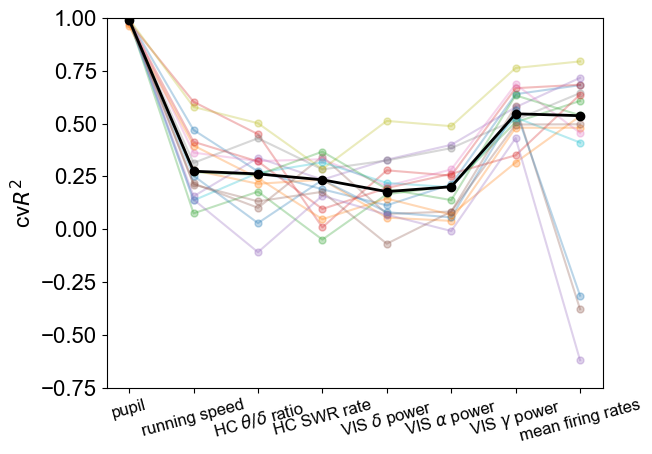

In [13]:
fig, ax = plt.subplots()

titles = ['pupil', 'running speed', r'HC $\theta/\delta$ ratio', 'HC SWR rate',
          'VIS $\delta$ power', r'VIS $\alpha$ power', 'VIS $\gamma$ power', 'mean firing rates']

plt.plot(LOO_scores[:,:,0].T, markersize=10, marker = '.', alpha=.3)
plt.plot(np.median(LOO_scores[:,:,0],axis=0), markersize=12, marker = '.', lw=2, color='k')
ax.set_xticks(np.arange(obs.shape[1]), labels = titles, rotation=15, fontsize=12)
ax.set_ylabel('cv$R^2$', fontsize=16)
ax.set_ylim([-.75,1])

plt.savefig(figdir + '/allen_r2plot_nonlin.pdf', dpi=300, transparent=True)

plt.show()

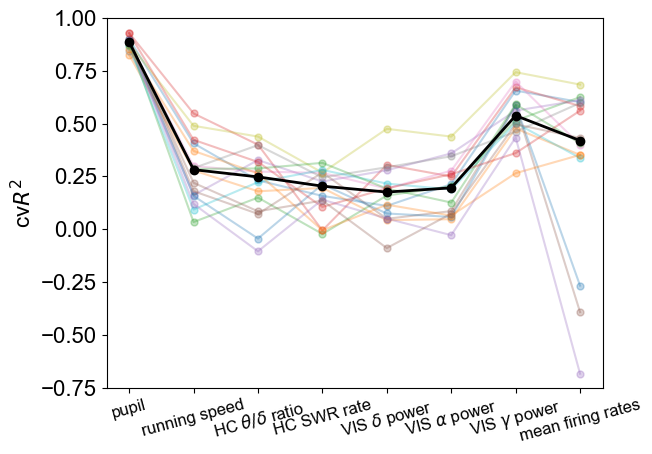

In [14]:
fig, ax = plt.subplots()

titles = ['pupil', 'running speed', r'HC $\theta/\delta$ ratio', 'HC SWR rate',
          'VIS $\delta$ power', r'VIS $\alpha$ power', 'VIS $\gamma$ power', 'mean firing rates']

plt.plot(LOO_scores[:,:,1].T, markersize=10, marker = '.', alpha=.3)
plt.plot(np.median(LOO_scores[:,:,1],axis=0), markersize=12, marker = '.', lw=2, color='k')
ax.set_xticks(np.arange(obs.shape[1]), labels = titles, rotation=15, fontsize=12)
ax.set_ylabel('cv$R^2$', fontsize=16)
ax.set_ylim([-.75,1])

plt.savefig(figdir + '/allen_r2plot_lin.pdf', dpi=300, transparent=True)

plt.show()

# Arousal manifold

In [15]:
## ENSEMBLE PREDICTIONS
num_bins = 100

lim = .75
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))

Z = np.zeros((num_bins,num_bins,obs.shape[1]))

tic()
j = 0
for d in decoders:
    print('Decoder ' + str(j+1) + '/' + str(len(decoders)))

    for i in range(num_bins): # col by col
        Z[:,i,:] = Z[:,i,:] + d.predict(np.vstack((xx[:,i],yy[:,i])).T,verbose=False)[:,:obs.shape[1]]
        
    j+=1
    
toc()

Decoder 1/16
Decoder 2/16
Decoder 3/16
Decoder 4/16
Decoder 5/16
Decoder 6/16
Decoder 7/16
Decoder 8/16
Decoder 9/16
Decoder 10/16
Decoder 11/16
Decoder 12/16
Decoder 13/16
Decoder 14/16
Decoder 15/16
Decoder 16/16
Elapsed time is 86.37734007835388 seconds.


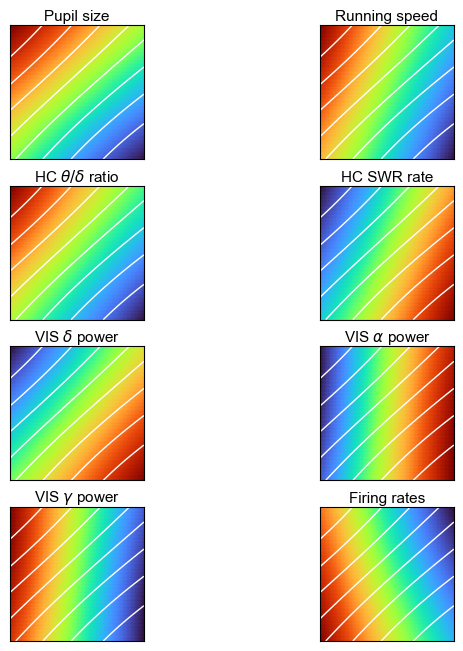

In [16]:
fig, ax = plt.subplots(4,2,figsize=(8,8))

ax = ax.ravel()
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=.2)

titles = ['Pupil size', 'Running speed', r'HC $\theta/\delta$ ratio', 'HC SWR rate',
          'VIS $\delta$ power', r'VIS $\alpha$ power', 'VIS $\gamma$ power', 'Firing rates']

for v in range(Z.shape[-1]):
    ax[v].grid(False)
    ax[v].axis('square')
    z = Z[:,:,v]
    p = ax[v].pcolormesh(xx, yy, z, edgecolors='face', cmap='turbo', vmin=np.min(z), vmax=np.max(z))
    
    levels = np.linspace(np.min(Z[:,:,0]), np.max(Z[:,:,0]), 10)
    ax[v].contour(xx, yy, Z[:,:,0], levels, colors='w', linestyles='solid', linewidths=1)

    ax[v].set_xlim([-lim,lim])
    ax[v].set_ylim([-lim,lim])

    ax[v].set_xticks([])
    ax[v].set_yticks([])
    
    ax[v].set_title(titles[v], size=11,**{'fontname':'Arial'}, pad=3)
    
#ax[0].set_xlabel('Latent dim. 1', size=12, **{'fontname':'Arial'})
#ax[0].set_ylabel('Latent dim. 2', size=12, **{'fontname':'Arial'})

plt.savefig(figdir + '/manifold_allen.pdf', dpi=300, transparent=True)

plt.show()

# Phase plane plot

In [17]:
## Create list containing latent dynamics for each mouse
z_list = xtrains.copy()
for i in range(len(xtrains)):
    z_list[i] = encoder.predict(xtrains[i])[0]

1117/1117 [==============================] - 2s 2ms/step


## Approximate a vector field via SINDy

In [18]:
# SR3 thresholding
sr3_optimizer = ps.SR3(thresholder="l0", threshold=.2)

# Instantiate and fit the SINDy model
sindy = ps.SINDy(
    optimizer=sr3_optimizer,
    differentiation_method=ps.SmoothedFiniteDifference(drop_endpoints=True),
    feature_library=ps.PolynomialLibrary(degree=3),
    feature_names=['x', 'y'] # x and y are latent variables z_1 and z_2
)

sindy.fit(z_list, t=dt, ensemble=True, quiet=True, multiple_trajectories=True)

sindy.print()

(x)' = 0.384 y
(y)' = -0.251 x + -0.193 x^2 y


## Simulate SDE and plot sample trajectory

In [19]:
# SINDy simulation
# t = np.arange(0, 200, dt) # 300 seconds
# z0 = [-.05,.05,.1]
# z_sim = sindy.simulate(z0, t)

In [20]:
# Define some SDE helper functions

def itoArousal(f, G, y0, tspan, omega=0, dW=None, generator=None):

    generator = np.random.default_rng()
    N = len(tspan)
    h = (tspan[N-1] - tspan[0])/(N - 1)
    d = len(y0)
    # allocate space for result
    y = np.zeros((N, d), dtype=y0.dtype)
    
    if dW is None:
        # pre-generate Wiener increments (for m independent Wiener processes):
        #dW = deltaW(N - 1, m, h, generator)
        dW = generator.normal(0.0, np.sqrt(h), (N-1, d))

    y[0] = y0
    for n in range(0, N-2):
        tn = tspan[n]
        yn = y[n]
        dWn = dW[n,:]
        y[n+1] = yn + f(yn, tn) * h + G(yn, tn, omega).dot(dWn)
    return y

def arousal(X, t):
    x = X[0]
    y = X[1]
    x_dot = .384*y
    y_dot = -.251*x - .193*x*x*y
    
    return np.array([x_dot, y_dot])
    
def G(x, t, omega=0):
    B = np.diag([omega,0])
    return B


In [21]:
# Integrate stochastic differential equation

num_steps = 10000
t = np.linspace(0., dt*num_steps, num_steps)
z0 = np.array([.2, .2,])

z_sim = itoArousal(arousal, G, z0, t, omega=.5)

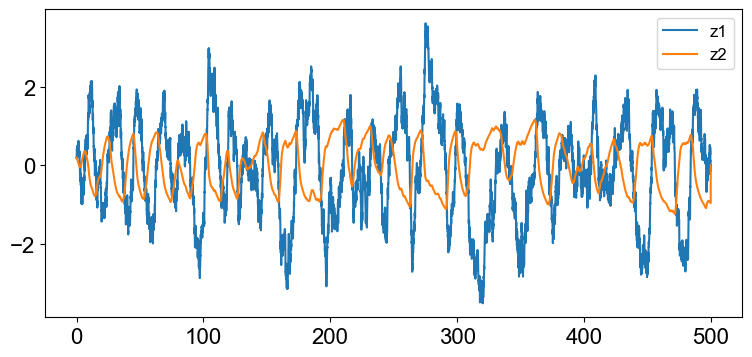

In [22]:
plt.figure(figsize=(9,4))
plt.plot(t,z_sim)
plt.legend(['z1','z2'],fontsize=12)
plt.show()

### Let's try reading out predicted pupil diameter (observerable 0) and hippocampal SWR rate (observable 3)

313/313 [==============================] - 0s 1ms/step


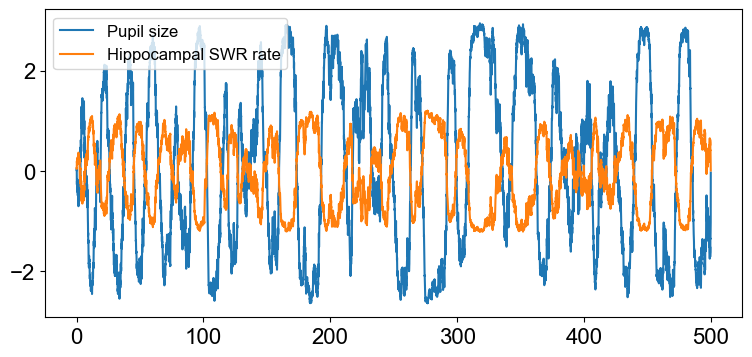

In [23]:
plt.figure(figsize=(9,4))
plt.plot(t,decoder.predict(z_sim)[:,[0,3]])
plt.legend(['Pupil size','Hippocampal SWR rate'],fontsize=12)
plt.show()

### ...compare with, e.g., Fig. 1C from McGinley et al. (2015) Neuron. Reasonable...

## Plot vector field

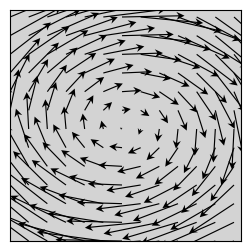

In [24]:
xx,yy = np.meshgrid(np.linspace(-lim,lim,num_bins),np.linspace(-lim,lim,num_bins))

fig, ax = plt.subplots(figsize=(7,3))

ax.grid(False)
ax.axis('square')

ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])

ax.set_xticks([])
ax.set_yticks([])

dx = xx.copy()
dy = xx.copy()
for i in range(num_bins): # col by col
    for j in range(num_bins):
        x = xx[i,j]
        y = yy[i,j]
        
        # plug in SINDY coeffs here      
        dx[i,j] = .384*y
        dy[i,j] = -.251*x -.193*x*x*y

# quiver plot
a = 8
ax.set_facecolor('lightgray')
ax.quiver(xx[::a,::a], yy[::a,::a], dx[::a,::a], dy[::a,::a], 
          color='k', scale=1, width=.005, angles='xy',
          headwidth=7, headlength=7, headaxislength=5)

# streamplot
# ax.set_facecolor('lightgray')
# ax.streamplot(xx[::a,::a], yy[::a,::a], dx[::a,::a], dy[::a,::a],
#               color='k',density=.6,linewidth=.8,arrowstyle ='->', 
#               arrowsize = 1)

plt.savefig(figdir + '/vector_field.pdf', dpi=300, transparent=True)

plt.show()